# # Generate Figure 2
Network distinct response states, in response to different input. A.  Exemplar population activity (n=10 stimuli) reduced in two principal components (PCAL2) over time for n=3 different synaptic reconfigurations (learning conditions). Only delay period is plotted. Time is in seconds. B. Same procedure (population PCAL2 activity) for two structured network instances, with all learning conditions (n=10) pooled together, each responding with K* > n. Clusters identified as in A. C. Boxplot of optimal number of clusters (K*) after k-means (see Methods) for each n=4 structured network instances of n=10 synaptic reshufflings (learning conditions), for n=10 stimuli.

Import necessary modules:

In [1]:
import notebook_module as nb
import analysis_tools as analysis
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import partial
from pathlib import Path
from pynwb import NWBHDF5IO
from itertools import chain
import matplotlib.gridspec as gridspec


# Create figure 2. 

<IPython.core.display.Javascript object>


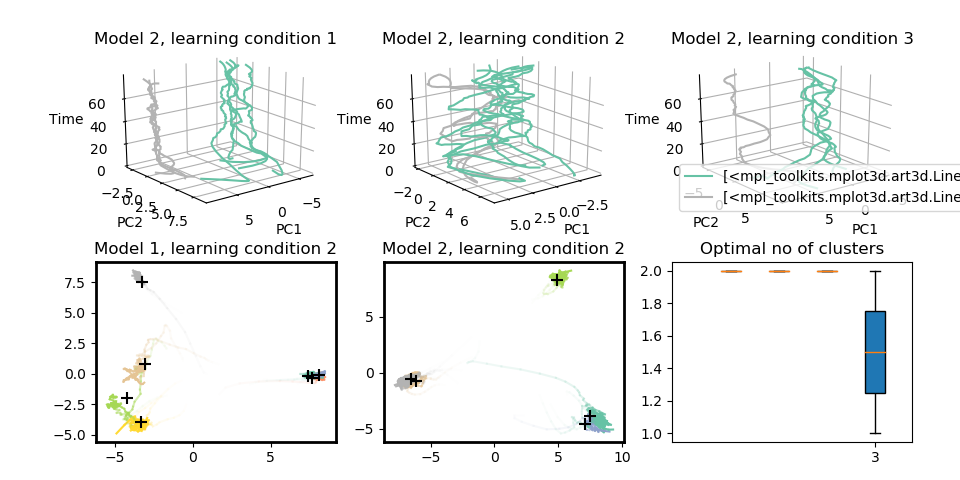

C:\Users\steve\AppData\Roaming\Python\Python37\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\steve\AppData\Roaming\Python\Python37\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\steve\AppData\Roaming\Python\Python37\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the futu

Cannot run kmeans with greater k than the data_pcapoints!


C:\Users\steve\AppData\Roaming\Python\Python37\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Cannot run kmeans with greater k than the data_pcapoints!


C:\Users\steve\AppData\Roaming\Python\Python37\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [2]:
subplot_width = 3
subplot_height = 2
figure2 = plt.figure(figsize=plt.figaspect(0.5))
figure2_axis = np.zeros((subplot_height, subplot_width), dtype=object)
for idx in range(subplot_width):
    figure2_axis[0, idx] = figure2.add_subplot(
        subplot_height, subplot_width, idx + 1, projection='3d'
    )

y_array = np.linspace(0.1, 100, 1000)
y_i = 500
no_of_conditions = 10

# Plot same animal model, different learning conditions:
conditions = [1, 2, 3]
for idx, learning_condition in enumerate(conditions):
    NWBfile = analysis.load_nwb_file(
        animal_model=2,
        learning_condition=learning_condition,
        experiment_config='structured',
        type='bn',
        data_path=simulations_dir
    )

    trial_len = analysis.get_acquisition_parameters(
        input_NWBfile=NWBfile,
        requested_parameters=['trial_len']
    )
    custom_range = (20, int(trial_len / 50))

    K_star, K_labels = analysis.determine_number_of_clusters(
        NWBfile_array=[NWBfile],
        max_clusters=no_of_conditions,
        y_array=y_array,
        custom_range=custom_range
    )

    # Plot the annotated clustering results:
    analysis.pcaL2(
        NWBfile_array=[NWBfile],
        klabels=K_labels[y_i, :].T,
        custom_range=custom_range,
        smooth=True, plot_3d=True,
        plot_axes=figure2_axis[0, idx]
    )


# Plot whole animal model state space:
for idx, animal_model in enumerate([1,2]):
    figure2_axis[1, idx] = figure2.add_subplot(
        subplot_height, subplot_width, 4 + idx
    )
    NWBfiles = [
        analysis.load_nwb_file(
            animal_model=animal_model,
            learning_condition=learning_condition,
            experiment_config='structured',
            type='bn',
            data_path=simulations_dir
        )
        for learning_condition in range(1, no_of_conditions + 1)
    ]

    trial_len, ntrials = analysis.get_acquisition_parameters(
        input_NWBfile=NWBfiles[0],
        requested_parameters=['trial_len', 'ntrials']
    )
    custom_range = (20, int(trial_len / 50))

    K_star, K_labels = analysis.determine_number_of_clusters(
        NWBfile_array=NWBfiles,
        max_clusters=no_of_conditions * ntrials,
        y_array=y_array,
        custom_range=custom_range
    )

    # Plot the annotated clustering results:
    analysis.pcaL2(
        NWBfile_array=NWBfiles,
        klabels=K_labels[y_i, :].T,
        custom_range=custom_range,
        smooth=True, plot_2d=True,
        plot_axes=figure2_axis[1, idx]
    )


# TODO: Plot number of clusters per animal/condition (na dw)
# Run for every learning condition and animal the k-means clustering:
figure2_axis[1, 2] = figure2.add_subplot(
    subplot_height, subplot_width, 6
)
no_of_animals = 4
optimal_clusters_of_group = defaultdict(partial(np.ndarray, 0))
for animal_model in range(1, no_of_animals + 1):
    # Pool together no of clusters for one animal model:
    K_star_over_trials = np.zeros((no_of_conditions, 1))
    for learning_condition in range(1, no_of_conditions + 1):
        # Lazy load the data as a NWB file. Easy to pass around and
        # encapsulates info like trial length, stim times etc.
        #TODO: this might raised some exceptions. Investigate!
        nwbfile = analysis.load_nwb_file(
            animal_model=animal_model,
            learning_condition=learning_condition,
            experiment_config='structured',
            type='bn',
            data_path=simulations_dir
        )

        trial_len = analysis.get_acquisition_parameters(
            input_NWBfile=nwbfile,
            requested_parameters=['trial_len']
        )

        # TODO: Where is custom range needed? determine a global way
        # of passing it around...
        custom_range = (20, int(trial_len / 50))

        K_star, K_labels = analysis.determine_number_of_clusters(
            NWBfile_array=[nwbfile],
            max_clusters=no_of_conditions,
            y_array=y_array,
            custom_range=custom_range
        )

        K_star_over_trials[learning_condition - 1, :] = \
            K_star[y_i]

    optimal_clusters_of_group[nb.datasetName(animal_model)] = \
        K_star_over_trials



figure2_axis[1, 2].set_title('Optimal no of clusters')
bplots = []
models_list = range(1, no_of_animals + 1)
for pos, animal in enumerate(models_list):
    bp = figure2_axis[1, 2].boxplot(
        optimal_clusters_of_group[nb.datasetName(animal)],
        positions=[pos],
        widths=0.4,
        patch_artist=True
    )
figure2_axis[1, 2].set_xlim(-1, 4)
figure2_axis[1, 2].set_xticks(list(range(no_of_animals)))
figure2_axis[1, 2].set_xticklabels(['Model 1', 'Model 2', 'Model 3', 'Model 4'])
figure2_axis[1, 2].set_ylabel('K*')
for tick in figure2_axis[1, 2].get_xticklabels():
    tick.set_rotation(45)

plt.subplots_adjust(top=0.92, bottom=0.15, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.25)




In [4]:
figure2.savefig('Figure_2.svg')
figure2.savefig('Figure_2.png')
print('Tutto pronto!')

Tutto pronto!
